<a href="https://colab.research.google.com/github/JBoixCampos/ERnet-v2/blob/main/ERnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERnet Transformer

## Install packages

In [14]:
!pip install sknw timm einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download files

In [15]:
# architectures
!mkdir -p archs
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/swinir_rcab_arch.py -P archs
!wget https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/rcan_arch.py -P archs

# models
!mkdir -p models
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/20220306_ER_4class_swinir_nch1.pth -P models

# image files
!mkdir -p images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage1.png -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage2.png -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage3-stack.tif -P images
!wget https://github.com/charlesnchr/ERnet-v2/releases/download/v2.0/TestImage4-stack.tif -P images

--2023-05-08 10:16:47--  https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/swinir_rcab_arch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50102 (49K) [text/plain]
Saving to: ‘archs/swinir_rcab_arch.py.10’

swinir_rcab_arch.py 100%[===================>]  48.93K  --.-KB/s    in 0.01s   

2023-05-08 10:16:47 (4.67 MB/s) - ‘archs/swinir_rcab_arch.py.10’ saved [50102/50102]

--2023-05-08 10:16:47--  https://raw.githubusercontent.com/charlesnchr/ERnet-v2/main/Training/archs/rcan_arch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

## Import packages

In [16]:
import os
import datetime
import math

import torch
import time 

import torch.nn as nn
from PIL import Image, ImageFile
from skimage import io,exposure,img_as_ubyte
import glob

import numpy as np
import os

from argparse import Namespace

import torchvision.transforms as transforms
import sys
import tqdm
import pprint

from tqdm.auto import tqdm

# Initialise

### Load ERnet Swin architecture

In [17]:
%reload_ext autoreload
%autoreload 2

import sys
import os

py_file_location = "archs"
sys.path.append(os.path.abspath(py_file_location))
from swinir_rcab_arch import SwinIR_RCAB
from rcan_arch import RCAN

# Functions

In [22]:
toTensor = transforms.ToTensor()  
toPIL = transforms.ToPILImage()      


def remove_dataparallel_wrapper(state_dict):
	r"""Converts a DataParallel model to a normal one by removing the "module."
	wrapper in the module dictionary

	Args:
		state_dict: a torch.nn.DataParallel state dictionary
	"""
	from collections import OrderedDict

	new_state_dict = OrderedDict()
	for k, vl in state_dict.items():
		name = k[7:] # remove 'module.' of DataParallel
		new_state_dict[name] = vl

	return new_state_dict


def changeColour(I): # change colours (used to match WEKA output, request by Meng)
    Inew = np.zeros(I.shape + (3,)).astype('uint8')
    for rowidx in range(I.shape[0]):
        for colidx in range(I.shape[1]):
            if I[rowidx][colidx] == 0:
                Inew[rowidx][colidx] = [198,118,255]
            elif I[rowidx][colidx] == 127:
                Inew[rowidx][colidx] = [79,255,130]
            elif I[rowidx][colidx] == 255:
                Inew[rowidx][colidx] = [255,0,0]
    return Inew



def AssembleStacks(basefolder):
    # export to tif
    
    folders = []
    folders.append(basefolder + '/in')
    folders.append(basefolder + '/out') 

    for subfolder in ['in','out']:
        folder = basefolder + '/' + subfolder
        if not os.path.isdir(folder): continue
        imgs = glob.glob(folder + '/*.jpg')
        imgs.extend(glob.glob(folder + '/*.png'))
        n = len(imgs)
        
        shape = io.imread(imgs[0]).shape
        h = shape[0]
        w = shape[1]
        
        if len(shape) == 2:
            I = np.zeros((n,h,w),dtype='uint8')
        else:
            c = shape[2]
            I = np.zeros((n,h,w,c),dtype='uint8')
        
        for nidx, imgfile in enumerate(imgs):
            img = io.imread(imgfile)
            I[nidx] = img

            print('%s : [%d/%d] loaded imgs' % (folder,nidx+1,len(imgs)),end='\r')
        print('')
        
        stackname = os.path.basename(basefolder)
        stackfilename = '%s/%s_%s.tif' % (basefolder,stackname,subfolder)
        io.imsave(stackfilename,I,compress=6)
        print('saved stack: %s' % stackfilename)



def processImage_tiled(net,opt,imgid,img,savepath_in,savepath_out):

    imageSize = opt.imageSize

    h,w = img.shape[0], img.shape[1]
    if imageSize == 0:
        imageSize = 250
        while imageSize+250 < h and imageSize+250 < w:
            imageSize += 250
        print('Set imageSize to',imageSize)

    device = torch.device('cuda' if torch.cuda.is_available() and not opt.cpu else 'cpu')

    # img_norm = (img - np.min(img)) / (np.max(img) - np.min(img)) 
    images = []

    images.append(img[:imageSize,:imageSize])
    images.append(img[h-imageSize:,:imageSize])
    images.append(img[:imageSize,w-imageSize:])
    images.append(img[h-imageSize:,w-imageSize:])

    proc_images = []
    for idx,sub_img in enumerate(images):
        # sub_img = (sub_img - np.min(sub_img)) / (np.max(sub_img) - np.min(sub_img))
        pil_sub_img = Image.fromarray((sub_img*255).astype('uint8'))
        
        # sub_tensor = torch.from_numpy(np.array(pil_sub_img)/255).float().unsqueeze(0)
        sub_tensor = toTensor(pil_sub_img)

        sub_tensor = sub_tensor.unsqueeze(0)

        with torch.no_grad():
            sr = net(sub_tensor.to(device))
            
            sr = sr.cpu()
            # sr = torch.clamp(sr,min=0,max=1)

            m = nn.LogSoftmax(dim=0)
            sr = m(sr[0])
            sr = sr.argmax(dim=0, keepdim=True)
            
            # pil_sr_img = Image.fromarray((255*(sr.float() / (opt.nch_out - 1)).squeeze().numpy()).astype('uint8'))
            pil_sr_img = toPIL(sr.float() / (opt.nch_out - 1))

            # pil_sr_img.save(opt.out + '/segmeneted_output_' + str(i) + '_' + str(idx) + '.png')
            # pil_sub_img.save(opt.out + '/imageinput_' + str(i) + '_' + str(idx) + '.png')

            proc_images.append(pil_sr_img)
        
    # stitch together
    img1 = proc_images[0]
    img2 = proc_images[1]
    img3 = proc_images[2]
    img4 = proc_images[3]

    woffset = (2*imageSize-w) // 2
    hoffset = (2*imageSize-h) // 2

    img1 = np.array(img1)[:imageSize-hoffset,:imageSize-woffset]
    img3 = np.array(img3)[:imageSize-hoffset,woffset:]
    top = np.concatenate((img1,img3),axis=1)

    img2 = np.array(img2)[hoffset:,:imageSize-woffset]
    img4 = np.array(img4)[hoffset:,woffset:]
    bot = np.concatenate((img2,img4),axis=1)

    oimg = np.concatenate((top,bot),axis=0)
    # crop?
    # oimg = oimg[10:-10,10:-10]
    # img = img[10:-10,10:-10]
    # remove boundaries? 
    # oimg[:10,:] = 0
    # oimg[-10:,:] = 0
    # oimg[:,:10] = 0
    # oimg[:,-10:] = 0

    if opt.stats_tubule_sheet:
        npix1 = np.sum(oimg == 170) # tubule
        npix2 = np.sum(oimg == 255) # sheet
        npix3 = np.sum(oimg == 85) # SBT

        npix = npix1+npix2+npix3
        opt.csvfid.write('%s,%0.4f,%0.4f,%0.4f\n' % (imgid,npix1/npix,npix2/npix,npix3/npix))
    if opt.weka_colours:
        oimg = changeColour(oimg)

    Image.fromarray(oimg).save(savepath_out)
    if opt.save_input:
        io.imsave(savepath_in,img_as_ubyte(img))
        
    # Image.fromarray((img*255).astype('uint8')).save('%s/input_%04d.png' % (opt.out,i))

def processImage(net,opt,imgid,img,savepath_in,savepath_out):

    imageSize = opt.imageSize

    h,w = img.shape[0], img.shape[1]

    device = torch.device('cuda' if torch.cuda.is_available() and not opt.cpu else 'cpu')

    # img_norm = (img - np.min(img)) / (np.max(img) - np.min(img)) 
    pil_sub_img = Image.fromarray((img*255).astype('uint8'))
        
    # sub_tensor = torch.from_numpy(np.array(pil_sub_img)/255).float().unsqueeze(0)
    sub_tensor = toTensor(pil_sub_img)

    if 'swin' in opt.weights and 'nch1' not in opt.weights:
        sub_tensor = torch.cat((sub_tensor,sub_tensor,sub_tensor),0)
    sub_tensor = sub_tensor.unsqueeze(0)


    with torch.no_grad():
        sr = net(sub_tensor.to(device))
        
        sr = sr.cpu()
        # sr = torch.clamp(sr,min=0,max=1)

        m = nn.LogSoftmax(dim=0)
        sr = m(sr[0])
        sr = sr.argmax(dim=0, keepdim=True)
        
        # pil_sr_img = Image.fromarray((255*(sr.float() / (opt.nch_out - 1)).squeeze().numpy()).astype('uint8'))
        pil_sr_img = toPIL(sr.float() / (opt.nch_out - 1))

        # pil_sr_img.save(opt.out + '/segmeneted_output_' + str(i) + '_' + str(idx) + '.png')
        # pil_sub_img.save(opt.out + '/imageinput_' + str(i) + '_' + str(idx) + '.png')


    oimg = np.array(pil_sr_img)

    # workaround for new order of classes
    sheet_ind = oimg == 255
    SBT_ind = oimg == 85
    tubule_ind = oimg == 170
    oimg[sheet_ind] = 85
    oimg[SBT_ind] = 170
    oimg[tubule_ind] = 255

    if opt.stats_tubule_sheet:
        npix1 = np.sum(oimg == 255) # tubule
        npix2 = np.sum(oimg == 85) # sheet
        npix3 = np.sum(oimg == 170) # SBT

        npix = npix1+npix2+npix3
        opt.csvfid.write('%s,%0.4f,%0.4f,%0.4f\n' % (imgid,npix1/npix,npix2/npix,npix3/npix))
    if opt.weka_colours:
        oimg = changeColour(oimg)

    Image.fromarray(oimg).save(savepath_out)
    if opt.save_input:
        io.imsave(savepath_in,img_as_ubyte(img))
        
    # Image.fromarray((img*255).astype('uint8')).save('%s/input_%04d.png' % (opt.out,i))



def EvaluateModel(opt):

    if opt.stats_tubule_sheet:
        # if opt.out == 'root':
        #     if opt.root[0].lower() in ['jpg','png','tif']:
        #         pardir = os.path.abspath(os.path.join(opt.root,os.pardir))
        #         opt.csvfid = open('%s/stats_tubule_sheet.csv' % pardir,'w')
        #     else:
        #         opt.csvfid = open('%s/stats_tubule_sheet.csv' % opt.root,'w')
        # else:
        #     opt.csvfid = open('%s/stats_tubule_sheet.csv' % opt.out,'w')
        opt.csvfid.write('Filename,Tubule fraction,Sheet fraction,SBT fraction\n')

    if opt.graph_metrics:
        opt.graphfid.write('Filename,no_nodes,no_edges,assortativity, clustering, compo, ratio_nodes, \
        ratio_edges, degree 1, degree 2, degree 3, degree 4, degree 5, degree 6\n')
        

    if 'swin' not in opt.weights:
        print('LOADING: CNN architecture')
        # RCAN model
        net = RCAN(opt)
    elif 'swin3d' in opt.weights:
        print('LOADING: Transformer architecture')
        # Swin model
        patch_size_t = 1 if 'nch1' in opt.weights else 3
        opt.task = 'segment'
        net = SwinTransformer3D_RCAB(
                opt,
                patch_size=(patch_size_t,4,4),
                in_chans=1,
                embed_dim=96,
                depths=[2, 2, 6, 2],
                num_heads=[3, 6, 12, 24],
                window_size=(2,7,7),
                mlp_ratio=4.,
                qkv_bias=True,
                qk_scale=None,
                drop_rate=0.,
                attn_drop_rate=0.,
                drop_path_rate=0.2,
                norm_layer=nn.LayerNorm,
                patch_norm=True,
                upscale=1,
                frozen_stages=-1,
                use_checkpoint=False,
                vis=False
            )
    elif 'swinir' in opt.weights:
        print('LOADING: Transformer architecture')
        # Swin model
        opt.task = 'segment'
        net = SwinIR_RCAB(
            opt,
            img_size=128,
            in_chans=1,
            upscale=1,
            use_checkpoint=False,
            vis=False
        )
    else:
        print('model architecture not inferred')

    device = torch.device('cuda' if torch.cuda.is_available() and not opt.cpu else 'cpu')
    net.to(device)

    checkpoint = torch.load(opt.weights, map_location=device)
    print('loading checkpoint',opt.weights)
    net.load_state_dict(checkpoint['state_dict'])

    if opt.root[0].split('.')[-1].lower() in ['png','jpg','tif']:
        imgs = opt.root
    else:
        imgs = []
        for ext in opt.ext:
            # imgs.extend(glob.glob(opt.root + '/*.jpg')) # scan only folder
            if len(imgs) == 0: # scan everything
                for dir in opt.root:
                    imgs.extend(glob.glob(dir + '/**/*.%s' % ext,recursive=True))


    # find total number of images to process
    nimgs = 0
    for imgidx, imgfile in enumerate(imgs):
        basepath, ext = os.path.splitext(imgfile)

        if ext.lower() == '.tif':
            img = io.imread(imgfile)
            if len(img.shape) == 2: # grayscale 
                nimgs += 1
            elif  img.shape[2] <= 3:
                nimgs += 1
            else: # t or z stack
                nimgs += img.shape[0]
        else:
            nimgs += 1

    outpaths = []
    imgcount = 0

    # primary loop
    for imgidx, imgfile in enumerate(tqdm(imgs)):
        basepath, ext = os.path.splitext(imgfile)

        if ext.lower() == '.tif':
            img = io.imread(imgfile)
        else:
            img = np.array(Image.open(imgfile))

        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = img.astype('float')


        if len(img.shape) > 2 and img.shape[2] <= 3:
            print('removing colour channel')
            img = np.max(img,2) # remove colour channel

        # img = io.imread(imgfile)
        # img = (img - np.min(img)) / (np.max(img) - np.min(img)) 

        # filenames for saving
        idxstr = '%04d' % imgidx
        if opt.out == 'root': # save next to orignal
            savepath_out = imgfile.replace(ext,'_out_' + idxstr + '.png')
            savepath_in = imgfile.replace(ext,'_in_' + idxstr + '.png')
            basesavepath_graphfigures = imgfile.replace(ext,'')
        else: 
            pass # not implemented

        # process image
        if len(img.shape) == 2:            
            # status
            # print("Segmentation,%d,%d" % (imgcount, nimgs))

            p1,p99 = np.percentile(img,1),np.percentile(img,99)
            print(img.shape,np.max(img),np.min(img))
            imgnorm = exposure.rescale_intensity(img,in_range=(p1,p99))
            print(imgnorm.shape,np.max(imgnorm),np.min(imgnorm))
            imgid = '%s:%s' % (os.path.basename(imgfile),idxstr)
            processImage(net,opt,imgid,imgnorm,savepath_in,savepath_out)
            
            # send result    
            outpaths.append(savepath_out)

            # graph processing
            if graph_metrics:
                # print("Graph metrics,%d,%d" % (imgcount, nimgs))

                graph_out_paths = performGraphProcessing(savepath_out,opt, basesavepath_graphfigures, imgid)

                outpaths.extend(graph_out_paths)

            imgcount += 1

        else: # more than 3 channels, assuming stack
            basefolder = basepath
            os.makedirs(basefolder,exist_ok=True)
            if opt.save_input:
                os.makedirs(basefolder + '/in',exist_ok=True)
            if opt.graph_metrics:
                os.makedirs(basefolder + '/graph',exist_ok=True)
            os.makedirs(basefolder + '/out',exist_ok=True)

            for subimgidx in tqdm(range(img.shape[0])):
                # status
                # print("Segmentation,%d,%d" % (imgcount, nimgs))

                idxstr = '%04d_%04d' % (imgidx,subimgidx)
                savepath_in = '%s/in/%s.png' % (basefolder,idxstr)
                savepath_out = '%s/out/%s.png' % (basefolder,idxstr)
                basesavepath_graphfigures = '%s/graph/%s' % (basefolder,idxstr)
                p1,p99 = np.percentile(img[subimgidx],1),np.percentile(img[subimgidx],99)
                imgnorm = exposure.rescale_intensity(img[subimgidx],in_range=(p1,p99))
                imgid = '%s:%s' % (os.path.basename(imgfile),idxstr)
                processImage(net,opt,imgid,imgnorm,savepath_in,savepath_out)

                # send result                
                outpaths.append(savepath_out)

                # graph processing
                if opt.graph_metrics:
                    # print("Graph metrics,%d,%d" % (imgcount, nimgs))

                    graph_out_paths = performGraphProcessing(savepath_out,opt, basesavepath_graphfigures,imgid)

                    outpaths.extend(graph_out_paths)

                imgcount += 1
            AssembleStacks(basefolder)


    if opt.stats_tubule_sheet:
        opt.csvfid.close()

    if opt.graph_metrics:
        opt.graphfid.close()

    print(outpaths)
    return outpaths


import cv2
import sknw
from skimage.morphology import skeletonize

def remove_isolated_pixels(image):
    connectivity = 8

    output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

    num_stats = output[0]
    labels = output[1]
    stats = output[2]

    new_image = image.copy()

    for label in range(num_stats):
        if stats[label,cv2.CC_STAT_AREA] < 50:
            new_image[labels == label] = 0

    return new_image


def binariseImage(I):
    if len(I.shape) > 2:
        ind = I[:,:,0] > 250
    else:
        ind = I > 250
    Ibin = np.zeros((I.shape[0],I.shape[1])).astype('uint8')
    Ibin[ind] = 255
    Ibin = remove_isolated_pixels(Ibin)
    return Ibin


def getGraph(img,basename):
    img = binariseImage(img) / 255
    ske = skeletonize(img).astype(np.uint16)
    # ske = img.astype('uint16')

    # build graph from skeleton
    graph = sknw.build_sknw(ske)

    # draw image
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap='gray')

    # draw edges by pts
    for (s,e) in graph.edges():
        ps = graph[s][e]['pts']
        plt.plot([ps[0,1],ps[-1,1]], [ps[0,0],ps[-1,0]], 'green')
        
    # draw node by o
    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    plt.plot(ps[:,1], ps[:,0], 'r.')

    # print('EDGES',graph.edges())
    # print('NODES',graph.nodes())
    
    plt.savefig('%s_fig.jpg' % basename, bbox_inches = 'tight', pad_inches = 0, dpi=300)
    plt.close()
    open('%s_edges.dat' % basename,'w').write(str(graph.edges()).replace('(','[').replace(')',']'))
    open('%s_nodes.dat' % basename,'w').write(str(graph.nodes()).replace('(','[').replace(')',']'))

    edges = np.array(graph.edges())

    return edges, nodes

import networkx as nx
import json
import matplotlib.pyplot as plt
import collections

plt.switch_backend('agg')


#build teh networkx graph from node and egdes lists 
def build_graph(nodes,edges):
    G=nx.Graph()
    G.add_nodes_from(nodes)
    for edge in edges:
        G.add_edge(edge[0],edge[1])
    return G

# perform some analysis 
def simple_analysis(G):
    no_nodes=G.number_of_nodes()
    no_edges=G.number_of_edges()
    assortativity = nx.degree_assortativity_coefficient(G)
    clustering = nx.average_clustering(G)
    compo = nx.number_connected_components(G)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    size_G0_edges = G0.number_of_edges()
    size_G0_nodes = G0.number_of_nodes()
    ratio_nodes=size_G0_nodes/no_nodes
    ratio_edges =size_G0_edges/no_edges
    return no_nodes,no_edges,assortativity, clustering, compo, ratio_nodes, ratio_edges

# here we generate a histogram of degrees with a specified colour
def degree_histogram(savepath,G,colour='blue'):
    plt.figure()

    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    fig1, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color=colour)
    plt.ylabel("Count")
    plt.xlabel("%Degree")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)
    plt.savefig(savepath)
    plt.close()

    print(deg,cnt)

    degrees = [0]*6 # ordered from deg. 1 to 6
    for _deg,_cnt in zip(deg,cnt):
        if _deg - 1 < 6:
            degrees[_deg - 1] = _cnt

    return degrees



# here we generate an image where nodes are coloured according to their degrees 
def graph_image(savepath,G):
    plt.figure()
    node_color = [float(G.degree(v)) for v in G]
    nx.draw_spring(G,node_size=10,node_color=node_color)
    plt.savefig(savepath)

    plt.close()



def performGraphProcessing(imgfile,opt, basename, imgid):
    
    savepath_hist = '%s_hist.png' % basename
    savepath_graph = '%s_graph.png' % basename

    img = io.imread(imgfile)
    edges, nodes = getGraph(img, basename)
    G=build_graph(nodes,edges)
    # metrics: no_nodes,no_edges,assortativity, clustering, compo, ratio_nodes, ratio_edges
    metrics = simple_analysis(G)
    degrees = degree_histogram(savepath_hist,G,'goldenrod')
    graph_image(savepath_graph,G)

    opt.graphfid.write('%s,%d,%d,%0.5f,%0.5f,%0.5f,%0.5f,%0.5f,%d,%d,%d,%d,%d,%d\n' % (imgid,*metrics,*degrees))

    plt.close()

    return [savepath_graph,savepath_hist]



def segment(exportdir,filepaths,weka_colours,stats_tubule_sheet,graph_metrics,save_in_original_folders,save_input=True):
    opt = Namespace()
    opt.root = filepaths
    opt.ext = ['jpg','png','tif']
    opt.stats_tubule_sheet = stats_tubule_sheet
    opt.graph_metrics = graph_metrics
    opt.weka_colours = weka_colours
    opt.save_input = save_input
    
    opt.exportdir = exportdir
    os.makedirs(exportdir,exist_ok=True)
    opt.jobname = datetime.datetime.utcnow().strftime('%Y%m%d%H%M%S%f')[:-3]

    if stats_tubule_sheet:
        csvfid_path = '%s/%s_stats_tubule_sheet.csv' % (opt.exportdir, opt.jobname)
        opt.csvfid = open(csvfid_path,'w')
    
    if opt.graph_metrics:
       graphfid_path = '%s/%s_graph_metrics.csv' % (opt.exportdir, opt.jobname)
       opt.graphfid = open(graphfid_path,'w')


    ## model specific 
    opt.imageSize = 600
    opt.n_resblocks = 10
    opt.n_resgroups = 3
    opt.n_feats = 64
    opt.reduction = 16
    opt.narch = 0
    opt.norm = None
    opt.nch_in = 1
    opt.nch_out = 4
    opt.cpu = False
    opt.weights = model
    opt.scale = 1
    
    
    if save_in_original_folders:
        opt.out = "root"

    # pprint.pprint(vars(opt))
    print(vars(opt))
    
    return EvaluateModel(opt)



# Inference

## Example of using ERnet Transformer on single images

In [19]:
exportdir = 'output'
filepaths = ['images/TestImage1.png','images/TestImage2.png']
model = 'models/20220306_ER_4class_swinir_nch1.pth'
weka_colours = False
stats_tubule_sheet = True
graph_metrics = True
save_in_original_folders = True
outpaths = segment(exportdir,filepaths,weka_colours,stats_tubule_sheet,graph_metrics,save_in_original_folders,model)


{'root': ['images/TestImage1.png', 'images/TestImage2.png'], 'ext': ['jpg', 'png', 'tif'], 'stats_tubule_sheet': True, 'graph_metrics': True, 'weka_colours': False, 'save_input': 'models/20220306_ER_4class_swinir_nch1.pth', 'exportdir': 'output', 'jobname': '20230508101650815', 'csvfid': <_io.TextIOWrapper name='output/20230508101650815_stats_tubule_sheet.csv' mode='w' encoding='UTF-8'>, 'graphfid': <_io.TextIOWrapper name='output/20230508101650815_graph_metrics.csv' mode='w' encoding='UTF-8'>, 'imageSize': 600, 'n_resblocks': 10, 'n_resgroups': 3, 'n_feats': 64, 'reduction': 16, 'narch': 0, 'norm': None, 'nch_in': 1, 'nch_out': 4, 'cpu': False, 'weights': 'models/20220306_ER_4class_swinir_nch1.pth', 'scale': 1, 'out': 'root'}
LOADING: Transformer architecture
loading checkpoint models/20220306_ER_4class_swinir_nch1.pth


  0%|          | 0/2 [00:00<?, ?it/s]

(1024, 1024) 1.0 0.0
(1024, 1024) 1.0 0.0
(5, 4, 3, 2, 1) (10, 132, 1107, 219, 1821)
(1024, 1024) 1.0 0.0
(1024, 1024) 1.0 0.0
(7, 6, 5, 4, 3, 2, 1) (5, 7, 27, 298, 2732, 208, 984)
['images/TestImage1_out_0000.png', 'images/TestImage1_graph.png', 'images/TestImage1_hist.png', 'images/TestImage2_out_0001.png', 'images/TestImage2_graph.png', 'images/TestImage2_hist.png']


### Visualise result

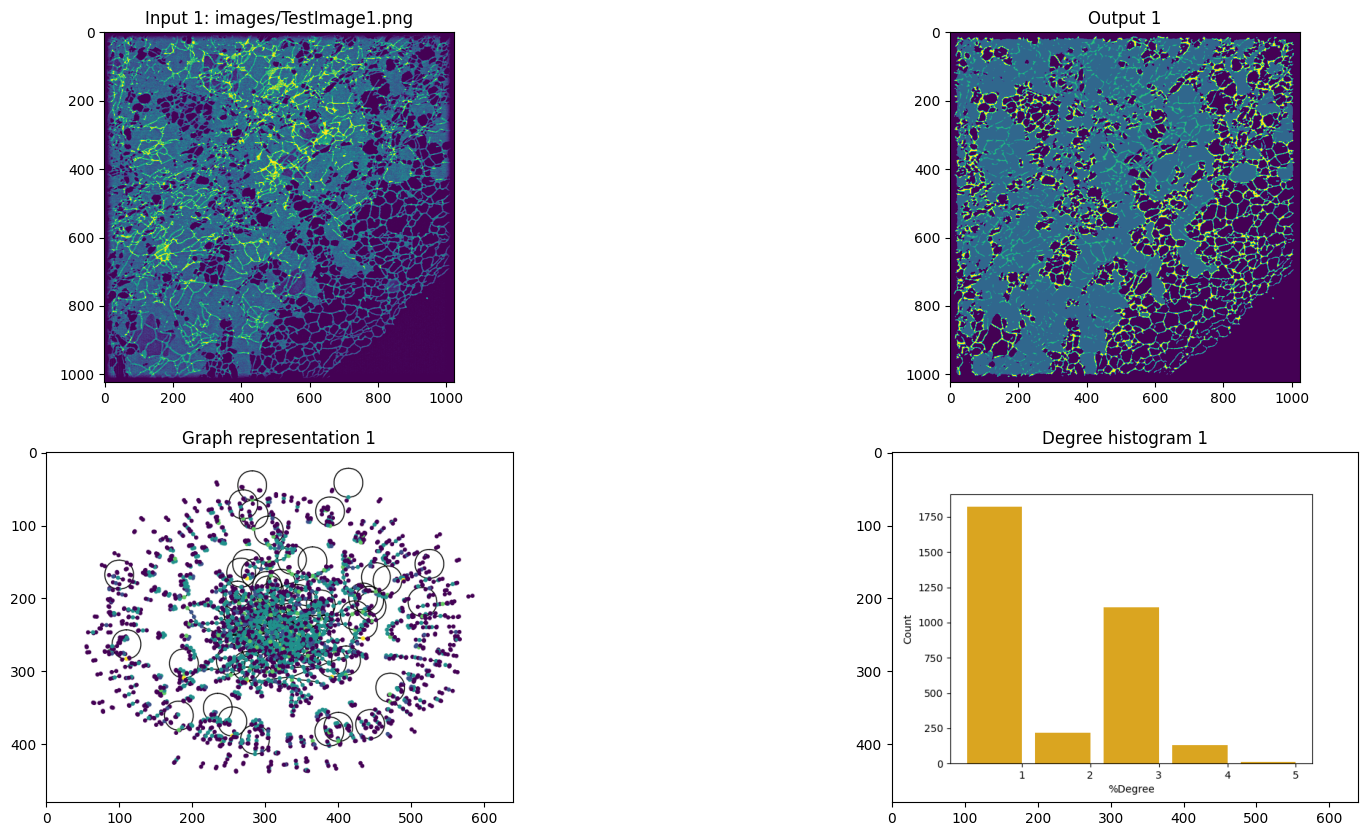

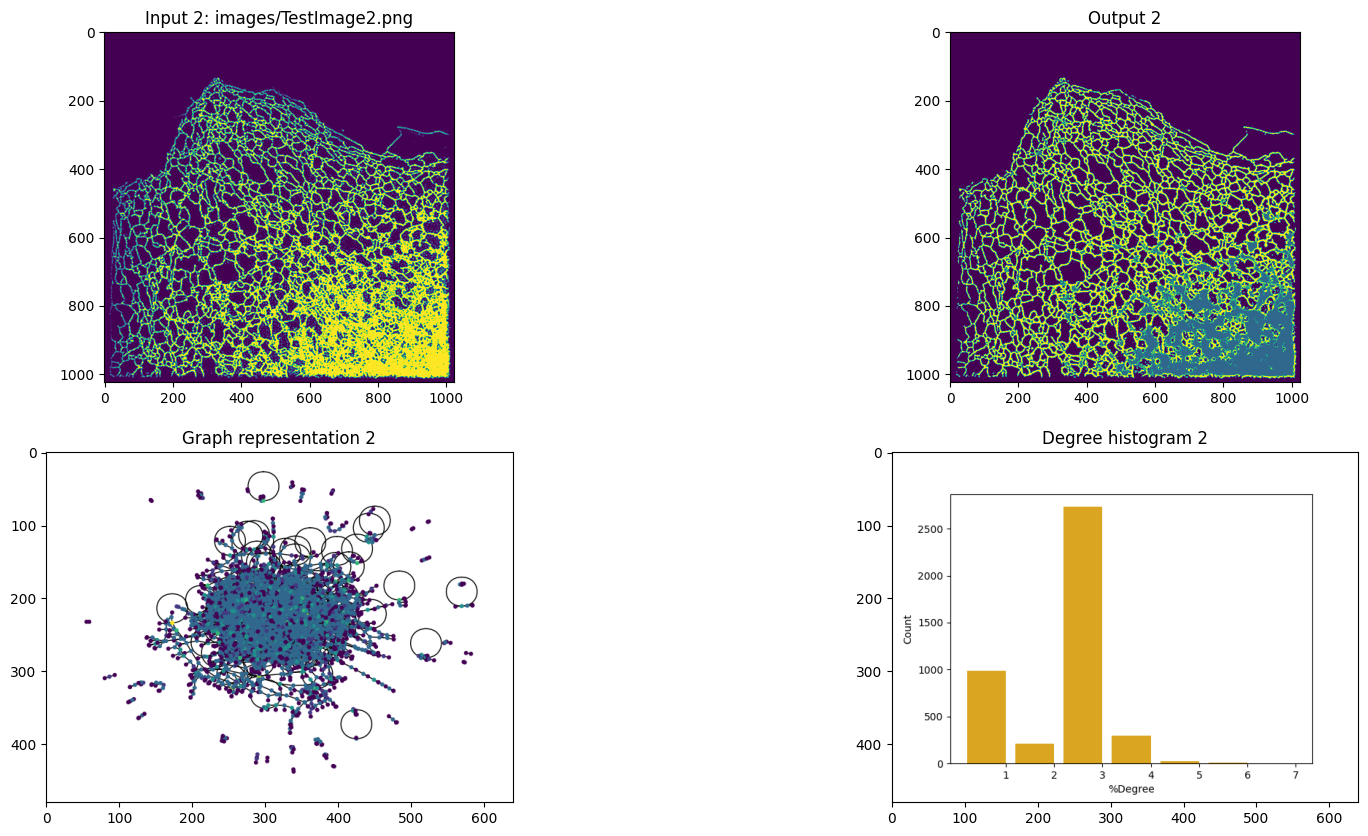

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# output files per input file
n = len(outpaths)//len(filepaths)

for idx, inpath in enumerate(filepaths):

    outpath = [outpaths[i] for i in range(idx*n, (idx+1)*n )]

    plt.figure(figsize=(20,10))
    plt.subplot(221)
    plt.imshow(io.imread(inpath))
    plt.title('Input %d: %s' % (idx+1,inpath))
    plt.subplot(222)
    plt.imshow(io.imread(outpath[0]))
    plt.title('Output %d' % (idx+1))

    plt.subplot(223)
    plt.imshow(io.imread(outpath[1]))
    plt.title('Graph representation %d' % (idx+1))
    plt.subplot(224)
    plt.imshow(io.imread(outpath[2]))
    plt.title('Degree histogram %d' % (idx+1))
plt.show()

## Example of batch processing

In [23]:
exportdir = 'output'
filepaths = ['images/TestImage3-stack.tif','images/TestImage4-stack.tif']
model = 'models/20220306_ER_4class_swinir_nch1.pth'
weka_colours = False
stats_tubule_sheet = True
graph_metrics = True
save_in_original_folders = True
outpaths = segment(exportdir,filepaths,weka_colours,stats_tubule_sheet,graph_metrics,save_in_original_folders,model)


{'root': ['images/TestImage3-stack.tif', 'images/TestImage4-stack.tif'], 'ext': ['jpg', 'png', 'tif'], 'stats_tubule_sheet': True, 'graph_metrics': True, 'weka_colours': False, 'save_input': 'models/20220306_ER_4class_swinir_nch1.pth', 'exportdir': 'output', 'jobname': '20230508102034122', 'csvfid': <_io.TextIOWrapper name='output/20230508102034122_stats_tubule_sheet.csv' mode='w' encoding='UTF-8'>, 'graphfid': <_io.TextIOWrapper name='output/20230508102034122_graph_metrics.csv' mode='w' encoding='UTF-8'>, 'imageSize': 600, 'n_resblocks': 10, 'n_resgroups': 3, 'n_feats': 64, 'reduction': 16, 'narch': 0, 'norm': None, 'nch_in': 1, 'nch_out': 4, 'cpu': False, 'weights': 'models/20220306_ER_4class_swinir_nch1.pth', 'scale': 1, 'out': 'root'}
LOADING: Transformer architecture
loading checkpoint models/20220306_ER_4class_swinir_nch1.pth


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(6, 5, 4, 3, 2, 1) (1, 15, 148, 902, 146, 1177)
(6, 5, 4, 3, 2, 1) (1, 7, 118, 916, 152, 1225)
(6, 5, 4, 3, 2, 1) (1, 10, 126, 895, 168, 1251)
(6, 5, 4, 3, 2, 1) (2, 12, 118, 935, 165, 1323)
(7, 6, 5, 4, 3, 2, 1) (1, 2, 7, 103, 925, 162, 1267)
images/TestImage3-stack/in : [5/5] loaded imgs


TypeError: ignored